# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

#### Import the libs

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#### Loading the data from a stata file

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


### Dataset with resumes that received callbacks

In [4]:
data_calls = data[['id','race','call', 'education', 'yearsexp']].loc[data['call']==1]
data_calls.head()

,id,race,call,education,yearsexp
85,b,w,1.0,2,7
95,b,w,1.0,2,4
105,b,w,1.0,4,6
107,b,b,1.0,4,6
126,b,b,1.0,4,9


### Callbacks for white and black-sounding names  (a summary)

In [5]:
# total résumés in the dataset
n = data.shape[0]

#Totals: callbacks and resumes tagged white-sounding names and black-sounding names
total_call = data['id'].loc[data['call'] ==1.0].count()
total_w = data['id'].loc[data['race'] == 'w'].count()
total_b = data['id'].loc[data['race'] == 'b'].count()

#Callbacks / race-sounding name 
call_w = data['id'].loc[(data['race'] =='w') & (data['call'] ==1.0)].count()
call_b = data['id'].loc[(data['race'] =='b') & (data['call'] ==1.0)].count()

#Ratio callback / resumes (white and black-sounding names)
ratio_w = call_w/total_w
ratio_b = call_b/total_b

# Summary
print("----------------------------------------------------------------------------------------------------------")
print("Total résumés = %s " % (format(n, ',')))
print("Total callbacks = %d calls (%.2f%% all CV)" % (total_call,(100*(total_call/n))))
print("Resumes tagged with white-sounding names = %s (%.2f%% all resumes)" %(format(total_w, ','), (100*(total_w/n))))
print("Resumes tagged with black-sounding names = %s (%.2f%% all resumes)" %(format(total_b, ','), (100*(total_b/n))))
print("...")
print("...Callback for white-sounding name = %d (%.2f%% resumes white-sounding names | %.2f%% of all callbacks |)" % (call_w, (100*ratio_w), (100*(call_w/total_call))))
print("...Callback for black-sounding name = %d (%.2f%% resumes black-sounding names | %.2f%% of all callbacks |)" % (call_b, (100*ratio_b),(100*(call_b/total_call))))
print("...")
print("...Callback for white-sounding name is %.2f%% greater than for black-sounding names" % (100*((ratio_w - ratio_b)/ratio_w)))
print("----------------------------------------------------------------------------------------------------------")

----------------------------------------------------------------------------------------------------------
Total résumés = 4,870 
Total callbacks = 392 calls (8.05% all CV)
Resumes tagged with white-sounding names = 2,435 (50.00% all resumes)
Resumes tagged with black-sounding names = 2,435 (50.00% all resumes)
...
...Callback for white-sounding name = 235 (9.65% resumes white-sounding names | 59.95% of all callbacks |)
...Callback for black-sounding name = 157 (6.45% resumes black-sounding names | 40.05% of all callbacks |)
...
...Callback for white-sounding name is 33.19% greater than for black-sounding names
----------------------------------------------------------------------------------------------------------


#### A cross tabulation (*crosstab*) - a special case of Pivot Tabel - that summarize callbacks/race:

In [6]:
pd.crosstab(data.call, data.race, margins=True)

race,b,w,All
call,,,
0.0,2278,2200,4478
1.0,157,235,392
All,2435,2435,4870


### Callbacks/race: a visual presentation

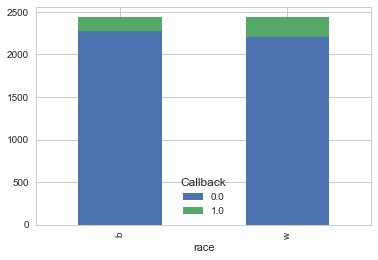

In [7]:
sns.set(style="whitegrid")
cross_tab = pd.crosstab(data.race, data.call)
cross_tab.plot.bar(stacked=True)
plt.legend(title='Callback')
plt.show()

### 1.What test is appropriate for this problem? Does CLT apply?

- We have a problem with variables that represents ***categorical values***: 'b', 'w'.<br>
- The question is about the the influence of race in the **rate** of callbacks: "...*whether race has a significant impact on the **rate** of callbacks for resumes..*"<br>
- The appropriate test is **two sample z-test** for **proportions**.

#### Does CLT apply?
Yes. 

### 2.What are the null and alternate hypotheses?

#### The investigative question:  *The race - identify with a white or black-sounding names in resumes - has a significant impact on the rate of callbacks for resumes*?
#### So far we have the following proportion for callbacks:

In [8]:
print("+------------------------------+---------------------------+")
print("| Resumes               Total  | %s                     |" % (format(n,',')))
print("|         white-sounding names | %s                     |" % format(total_w, ','))
print("|         black-sounding names | %s                     |" % format(total_b, ','))
print("+------------------------------+---------------------------+")
print("| Callbacks (total)            | %d calls (%.2f%% all CV)  |" % (total_call,(100*(total_call/n))))
print("|------------------------------|---------------------------|")
print("| Call for white-sounding name | %d (%.2f%% ws* resumes)   |" % (call_w, 100*ratio_w))
print("| Call for black-sounding name | %d (%.2f%% bs* resumes)   |" % (call_b, 100*ratio_b))
print("+------------------------------+---------------------------+")
print("* ws= resumes with white-sounding names  | bs= resumes with black-sounding names")
print("")
print("Callback for white-sounding name is %.2f%% greater than for black-sounding names" % (100*((ratio_w - ratio_b)/ratio_w)))

+------------------------------+---------------------------+
| Resumes               Total  | 4,870                     |
|         white-sounding names | 2,435                     |
|         black-sounding names | 2,435                     |
+------------------------------+---------------------------+
| Callbacks (total)            | 392 calls (8.05% all CV)  |
|------------------------------|---------------------------|
| Call for white-sounding name | 235 (9.65% ws* resumes)   |
| Call for black-sounding name | 157 (6.45% bs* resumes)   |
+------------------------------+---------------------------+
* ws= resumes with white-sounding names  | bs= resumes with black-sounding names

Callback for white-sounding name is 33.19% greater than for black-sounding names


### Hypothesis:

#### 2.1 Null hypothesis: **H0 => "Race has NOT a significant impact on the rate of callbacks for résumés"**. In other words, the **rate** or **proportion** between callbacks for white and black-sounding names is the same: **50%**.

#### 2.2 - Alternative hypothesis: **Ha => "Race has a significant impact on the rate of callbacks for résumés"**. In other words, the **rate** or **proportion** between callbacks for white and black-sounding names is not the same: **not equal to 50%**.

### 3. Compute margin of error, confidence interval, and p-value

![estimate](images/img_estimate.png)

### Confidence Interval for the Difference of Two Population Proportions:

![confidence interval for proportions](images/img_ci_forproportion.png)

### Where:

#### Note: we are considering that we hava a confidence level : 95%. Thus, alpha level (alpha) = 5%. The z-score associated with a 5% alpha level / 2 is Z = 1.96

In [9]:
#Ratio callback / resumes (white and black-sounding names)
#Ratios were calculated above
p1 = ratio_w
p2 = ratio_b

# Z value (see note above)
Z_SCORE = 1.96

# Total resumes with white-sounding names
n1 = total_w

# Total resumes with black-sounding names
n2 = total_b

print("+----|-------|---------------------------------------+")
print("| p1 | %.2f%% | %% callback / total resumes ws*        |" % (100*p1))
print("|----|-------|---------------------------------------|")
print("| p2 | %.2f%% | %% callback / total resumes bs*        |" % (100*p2))
print("|----|-------|---------------------------------------|")
print("| Z  | %.2f  | Z value, based on 95% confidence level|")
print("|----|-------|---------------------------------------|")
print("| n1 | %s | total resumes ws*                     |" % format(total_w, ','))
print("|----|-------|---------------------------------------|")
print("| n2 | %s | total resumes bs*                     |" % format(total_b, ',')) 
print("+----|-------|---------------------------------------+")
print("")
print("* ws= resumes with white-sounding names  | bs= resumes with black-sounding names")
print("")

+----|-------|---------------------------------------+
| p1 | 9.65% | % callback / total resumes ws*        |
|----|-------|---------------------------------------|
| p2 | 6.45% | % callback / total resumes bs*        |
|----|-------|---------------------------------------|
| Z  | %.2f  | Z value, based on 95% confidence level|
|----|-------|---------------------------------------|
| n1 | 2,435 | total resumes ws*                     |
|----|-------|---------------------------------------|
| n2 | 2,435 | total resumes bs*                     |
+----|-------|---------------------------------------+

* ws= resumes with white-sounding names  | bs= resumes with black-sounding names



### So, the Confidence Interval for the Difference of Two Population Proportions (p1 - p2):

In [10]:
estimate = (p1-p2)
margin_of_error = Z_SCORE * np.sqrt(((p1*(1-p1))/n1)+((p2*(1-p2))/n2))
low_value   = estimate - margin_of_error
high_value = estimate + margin_of_error
print("Estimate = %.4f " %estimate)
print("Margin of Error = %.4f" %margin_of_error)
print("------------------------------------------")
print("Estimate %.4f +/- %.4f" %(estimate, margin_of_error))
print("Interval: (%.4f, %.4f)" %(low_value, high_value))

Estimate = 0.0320 
Margin of Error = 0.0153
------------------------------------------
Estimate 0.0320 +/- 0.0153
Interval: (0.0168, 0.0473)


### The Ho *null* hypothesis is True of False?

![std error and z value](images/img_z_formula_stderror.png)

#### Calculating the SEo(p1 - p2):

In [11]:
# P-hat, p = (x1+x2)/(n1+n2)
p = (call_w + call_b)/(total_w+total_b)

# SEo (see formula above)
std_error = np.sqrt((p*(1-p))*((1/total_w) + (1/total_b)))

# Z value = (p1-p2) / SEo
z_value = (ratio_w - ratio_b)/ std_error

print("P-hat: p = %.4f" %p)
print("SEo: std_error = %.4f" %std_error)
print("+------------------------+")
print("| Z   | %.4f           |" %z_value )
print("+------------------------+")

P-hat: p = 0.0805
SEo: std_error = 0.0078
+------------------------+
| Z   | 4.1084           |
+------------------------+


* p-value

In [12]:
if(z_value > Z_SCORE): 
    print("False: we reject the null hypothesis!")
else:
    print("True: we accept the null hypothesis!")

False: we reject the null hypothesis!


### Conclusion:
#### => There is evidence that race do impact on the rate of callbacks.

### 4. Write a story describing the statistical significance in the context or the original problem.

According to this definition[7]: *In statistical hypothesis testing, **a result has statistical significance when it is very unlikely to have occurred given the null hypothesis** *. In other words, Statistical Significance means the effect observed in the sample - greater callbacks (+33%) for white-sounding names - was unlikely to have occurred due to chance alone.

The races - 'b' and 'w' - were randomly tagged on résumés, before to be sent to the employer.

So, ...


### 5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

The analysis presented does not checked how other important variables could impact in the decision to callback or not a specific candidate; e.g.: education, years of experience, specific occupation  etc.

## References:

[1] "Statistics in a Nutshell", Boslaugh S., Watters A., O'Reilly (2008): https://www.amazon.com/Statistics-Nutshell-Desktop-Reference-OReilly/dp/0596510497/ref=sr_1_2?ie=UTF8&qid=1517168318&sr=8-2&keywords=Statistics+in+a+Nutshell%22%2C+Boslaugh 

[2] Documentation of "Scipy.Stats.TTest_ind": https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html#scipy.stats.ttest_ind 

[3] "**Distribution of the Difference Between two Proportions**". Link: http://www.kean.edu/~fosborne/bstat/05d2pops.html. Last access: 02/03/2018

[4] **Z Test and Two proportion Z-Test**". Link: http://www.statisticshowto.com/z-test/

[5]"**Proportion Z Test**", video on YouTube: https://youtu.be/Pkyb05DZdZg. Last access: 02/03/2018

[6] "**Working with Data Using pandas and Python 3**". Link: https://www.digitalocean.com/community/tutorials/working-with-data-using-pandas-and-python-3. Last access: 02/03/2018 

[7] "**Statistical significance**", definition on Wikipedia. Link: https://en.wikipedia.org/wiki/Statistical_significance. Last access: 02/05/2018 

[8] Video "Confidence Interval for the Difference Between Proportions": https://www.youtube.com/watch?v=0h8dgKTOPuM. Last access: 02/12/2018

[9] "Inference for Two Proportions: An Example of a Confidence Interval and a Hypothesis Test". Video: https://youtu.be/OIYkOiQX3fk. Last access: 02/13/2018

## Sandbox:

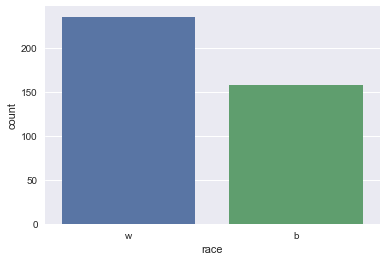

In [13]:
# A simple visual presentation with the total callbacks/race-sounding names 
sns.set(style="darkgrid")
ax = sns.countplot(x="race", data=data_calls[['race', 'call']])

### Margin of error and confidence intervals for 'w' and 'b' groups

* White-sounding names

In [14]:
margin_error = Z_SCORE * np.sqrt((p1*(1-p1))*(1/n1 + 1/n2))
low_critical_value = p1 - margin_error
high_critical_value = p1 + margin_error
print("White-sounding names:")
print("---------------------")
print("Mean: ", p1)
print("Margin of error: ", margin_error)
print("---------------------")
print("Confidence interval: ")
print("...From = %.2f" %low_critical_value)
print("...To   = %.2f" %high_critical_value)

White-sounding names:
---------------------
Mean:  0.09650924024640657
Margin of error:  0.01658700182375531
---------------------
Confidence interval: 
...From = 0.08
...To   = 0.11


* Black-sounding names

In [15]:
margin_error = Z_SCORE * np.sqrt((p2*(1-p2))*(1/n1 + 1/n2))
low_critical_value = p2 - margin_error
high_critical_value = p2 + margin_error
print("Black-sounding names:")
print("---------------------")
print("Mean: ", p1)
print("Margin of error: ", margin_error)
print("---------------------")
print("Confidence interval: ")
print("...From = %.2f" %low_critical_value)
print("...To   = %.2f" %high_critical_value)

Black-sounding names:
---------------------
Mean:  0.09650924024640657
Margin of error:  0.013795876786165097
---------------------
Confidence interval: 
...From = 0.05
...To   = 0.08


### Investigation: is there any relation between white/black-sounding names and education versus years of experience?

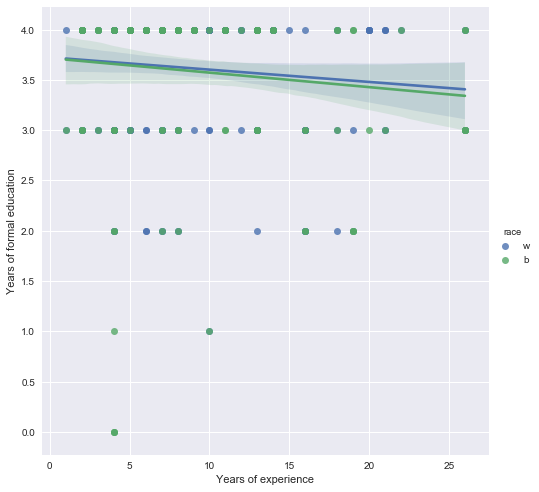

In [16]:
sns.set()

# Plot tip as a function of toal bill across days
g = sns.lmplot(x="yearsexp", y="education", hue="race",
               truncate=True, size=7, data=data_calls)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Years of experience", "Years of formal education")

### Summary:

In [17]:
# Total résumés
n = data.shape[0]

# Total callbacks
n_call = data_calls.shape[0]

# Résumés white and black sounding names
total_white = data['id'].loc[(data['race'] =='w')].count()
total_black = data['id'].loc[(data['race'] =='b')].count()

# Perc.(%) white and black sounding names from total
perc_tot_white = total_white/n
perc_tot_black = total_black/n

# Perc.(%) white and black sounding names with callback
perc_call_white = call_w/n_call
perc_call_black = call_b/n_call

print("Total résumés with callback = %d" %n_call)
print("---------------------------------")
print("Perc.(%%) white-sounding names from total = %.2f%%" %(perc_tot_white*100))
print("Perc.(%%) black-sounding names from total = %.2f%%" %(perc_tot_black*100))
print("---------------------------------")
print("Perc.(%%) white-sounding names from callbacks = %.2f%%" %(perc_call_white*100))
print("Perc.(%%) black-sounding names from total = %.2f%%" %(perc_call_black*100))
print("---------------------------------")

Total résumés with callback = 392
---------------------------------
Perc.(%) white-sounding names from total = 50.00%
Perc.(%) black-sounding names from total = 50.00%
---------------------------------
Perc.(%) white-sounding names from callbacks = 59.95%
Perc.(%) black-sounding names from total = 40.05%
---------------------------------
